In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy
import imageio
from PIL import Image
import json
from scipy.spatial import Delaunay
import skimage as ski
import einops
import harris

def read_img(img_name, img_dir = 'in_dir/', grayscale=False, r=None):
    if '.' not in img_name:
        img_name += '.jpg'
    img = Image.open(img_dir + '/' + img_name)
    if grayscale:
        img = img.convert('L')
    img = np.array(img)
    img = img / 255
    if r:
        img = np.rot90(img, k=r)
    return img
images_out = 'images_out/part_b' 
def save_img(fname, img_out, out_dir = 'images_out/part_b/', grayscale=False):
    if '.jpg' not in fname:
        fname = fname + '.jpg'
    full_name = out_dir + '/' + fname
    img_out = np.clip(img_out, a_min=0, a_max=1)
    # img_out = (img_out*255).astype(np.uint8)
    if grayscale:
        imageio.imwrite(full_name, img_out)
    else:
        plt.imsave(full_name, img_out)

In [2]:
# Computes the homography p’=Hp, where H
# is a 3x3 matrix with 8 degrees of freedom
def compute_h(img_1_pts, img_2_pts):
    assert len(img_1_pts) == len(img_2_pts)
    n = len(img_1_pts)
    img_1_pts = np.asarray(img_1_pts)
    img_1_hom = to_homogenous(img_1_pts)
    img_2_pts = np.asarray(img_2_pts)
    img_2_pts_flat = np.ndarray.flatten(img_2_pts)
    
    len_H = 8
    A = np.zeros((2*n, len_H))

    A[0:-1:2, :3] = img_1_hom.T # Set first 3 columns with p
    A[1::2, 3:6] = img_1_hom.T  # Set columns 3-5 with p

    # Set end columns with p
    A[::2, -2:] = img_1_pts 
    A[1::2, -2:] = img_1_pts 

    # Multiply end columns with p'
    A[:, -2] *= -img_2_pts_flat
    A[:, -1] *= -img_2_pts_flat
    b = img_2_pts_flat
    x, res, rank, _ = np.linalg.lstsq(A, b, rcond=None)
    H = np.ones(9)
    H[:8] = x
    H = np.reshape(H, (3,3))
    return H, res, rank
# Adds ones on axis 1
def to_homogenous(inp):
    inp = np.asarray(inp)
    ones = np.ones((inp.shape[0],1))
    return np.concatenate((inp, ones), axis=1).T

# Takes homogenous points and returns normal
def homogenous_to_non(inp):
    inp = np.asarray(inp)
    z = inp[-1, :]
    inp = inp[:-1, :] / z
    return inp.T

# Applies homography to non-homogenous coordinate inp, returning the new coords
# also in non-homogenous form
def apply_h(h, inp):
    homo = to_homogenous(inp)
    transformed = h @ homo
    return homogenous_to_non(transformed)

def get_corners(img):
    img_corners = [[img.shape[1], img.shape[0]], [img.shape[1], 0], [0,0], [0, img.shape[0]]]
    return img_corners

def get_inv(A):
    return np.linalg.inv(A)

# Takes in non-homogenous points
def create_polygon(points):
    points = np.asarray(points)
    cc, rr = ski.draw.polygon(points[:,0], points[:,1], shape=None)
    return cc,rr

In [3]:
### Tests to confirm homography calculated correctly
img_1_pts = [[6,1], [2,4], [3,7], [5,4]]
img_1_pts = np.asarray(img_1_pts)
img_1_hom = to_homogenous(img_1_pts)
ans = compute_h(img_1_pts, img_1_pts)
H = ans[0]
after_H = H @ img_1_hom
assert np.all(np.isclose(img_1_hom, after_H))

H = [[10,4,6],
     [2.3,4.3,-4],
     [0, 0, 1]]
img_2_hom = H @ img_1_hom
img_2_normal = homogenous_to_non(img_2_hom)
ans = compute_h(img_1_pts, img_2_normal)
H_computed = ans[0]
assert np.all(np.isclose(H, H_computed))

In [4]:
def load_corr_pts(fname, in_dir='images_in/', single=True):
    if 'json' not in fname: fname += '.json'
    corr_file = in_dir + fname
    f = open(corr_file)
    correspondences = json.load(f)
    img_1_points = np.array(correspondences['im1Points'])
    img_2_points = np.array(correspondences['im2Points'])
    if single:
        return img_1_points
    else:
        return img_1_points, img_2_points

def plot_pts(pts, color='blue', size=5, label=True, transpose=False, swap=False):
    if transpose:
        x, y = pts[1, :], pts[0, :]
    else:
        x, y = pts[:, 0], pts[:, 1]
    if swap:
        temp = x
        x = y
        y = temp
    if label:
        [plt.text(x[i], y[i], f'{i}', fontsize=10, ha='right', color=color) for i in range(len(x))]
    plt.scatter(x,y, color=color, s=size)

In [6]:
# Sets up img for interpolation
def create_interp_grid(img):
    X, Y = np.mgrid[:img.shape[0], :img.shape[1]]
    points = np.dstack((X.ravel(), Y.ravel())).squeeze()
    # Flatten img to use for interpolation
    flat_img = einops.rearrange(img, ('h w c -> (h w) c'))
    color_interp = scipy.interpolate.NearestNDInterpolator(points, flat_img)
    return color_interp

# Applies homography to img
def warp(H, img, new_shape = None, color_interp=None, out_dir='images_out/part_a/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(get_corners(new_image))
    src_coords = np.array([cc, rr, np.ones_like(rr)])

    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.ones(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.ones(3))

    # new_image[rr, cc] = tri_interp
    new_image[rr, cc] = tri_interp_mask_rc
    plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

In [7]:
def shift_pts(pts, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    new_pts = pts.copy()
    for i in range(len(pts)):
        new_pts[i] = pts[i][0] + (-1)**(i<2)* w_extend + offset_x, pts[i][1] + (-1)**(i==0 or i==3)* h_extend + offset_y
    return new_pts
        
def get_pts_from_corner(pts, tl, br, w_extend=0, h_extend=0, offset_x=0, offset_y=0):
    top_left, bottom_right = pts[tl], pts[br]
    h, w = -top_left[1] + bottom_right[1], bottom_right[0] - top_left[0]
    top_right = bottom_right[0], bottom_right[1] - h
    bottom_left = bottom_right[0] - w, bottom_right[1]
    pts = np.asarray([top_left, bottom_left, bottom_right, top_right])
    return shift_pts(pts, w_extend=w_extend, h_extend=h_extend, offset_x=offset_x, offset_y=offset_y)

### Part 1: Harris

In [8]:
def downsample(img, scale_factor, channels=True):
    if channels:
        return ski.transform.rescale(img, 1/scale_factor, anti_aliasing=True,channel_axis=-1)
    else:
        return ski.transform.rescale(img, 1/scale_factor, anti_aliasing=True)

In [187]:
from skimage.feature import corner_harris, peak_local_max
from skimage.color import rgb2gray

def get_harris_corners(im, min_dist=1, edge_discard=20):
    """
    This function takes a b&w image and an optional amount to discard
    on the edge (default is 5 pixels), and finds all harris corners
    in the image. Harris corners near the edge are discarded and the
    coordinates of the remaining corners are returned. A 2d array (h)
    containing the h value of every pixel is also returned.

    h is the same shape as the original image, im.
    coords is 2 x n (ys, xs).
    """
    assert edge_discard >= 20
    if len(im.shape) == 3:
        im = rgb2gray(im)
    if im.shape[0] > 2000: min_dist=5
    
    # find harris corners
    h = corner_harris(im, method='eps', sigma=1)
    coords = peak_local_max(h, min_distance=min_dist, indices=True)

    # discard points on edge
    edge = edge_discard  # pixels
    mask = (coords[:, 0] > edge) & \
           (coords[:, 0] < im.shape[0] - edge) & \
           (coords[:, 1] > edge) & \
           (coords[:, 1] < im.shape[1] - edge)
    coords = coords[mask].T
    
    mask = np.zeros_like(h)
    mask[edge:-edge, edge:-edge] = 1
    h = h*mask

    return h, coords


def dist2(x, c):
    """
    dist2  Calculates squared distance between two sets of points.

    Description
    D = DIST2(X, C) takes two matrices of vectors and calculates the
    squared Euclidean distance between them.  Both matrices must be of
    the same column dimension.  If X has M rows and N columns, and C has
    L rows and N columns, then the result has M rows and L columns.  The
    I, Jth entry is the  squared distance from the Ith row of X to the
    Jth row of C.

    Adapted from code by Christopher M Bishop and Ian T Nabney.
    """
    
    ndata, dimx = x.shape
    ncenters, dimc = c.shape
    assert(dimx == dimc, 'Data dimension does not match dimension of centers')

    return (np.ones((ncenters, 1)) * np.sum((x**2).T, axis=0)).T + \
            np.ones((   ndata, 1)) * np.sum((c**2).T, axis=0)    - \
            2 * np.inner(x, c)

<>:56: SyntaxWarning: assertion is always true, perhaps remove parentheses?
<>:56: SyntaxWarning: assertion is always true, perhaps remove parentheses?
/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:56: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(dimx == dimc, 'Data dimension does not match dimension of centers')


In [127]:
img_dir = 'images_in/'

def read_image_set(name, step, scale_factor=None, img_dir = 'images_in/', save_dir='images_out/part_b/part_1/', transpose=True, save=False):
    images = []
    for i in range(3):
        fname = name+'_'+str(1+step*i)
        img = read_img(fname, img_dir=img_dir)
        if transpose:
            img = np.rot90(img, k=3)
        if scale_factor:
            img = downsample(img, scale_factor)
            fname += '_' + str(scale_factor)
        if save:
            save_img(fname, img, out_dir=save_dir)
        images.append(img)
    return images

def get_top_k(h, pts, k=4000):
    # idx = np.argpartition(h.ravel(), h.size-k)[-k:]
    # return np.column_stack(np.unravel_index(idx, h.shape))
    sub_h = h[pts[:,0], pts[:,1]]
    sorted_idx = np.argsort(-sub_h)[:k]
    # print(sorted_idx.shape, sub_h.shape, pts.shape)
    return pts[sorted_idx]

In [70]:
vlsb_images = read_image_set('vlsb', 1, scale_factor=1, transpose=True, save=False)
# evans_images = read_image_set('evans', 2, scale_factor=4, save=True)
# garin_images = read_image_set('garin', 1, scale_factor=4, save=True)
part_1_out_dir = 'images_out/part_b/part_1/'

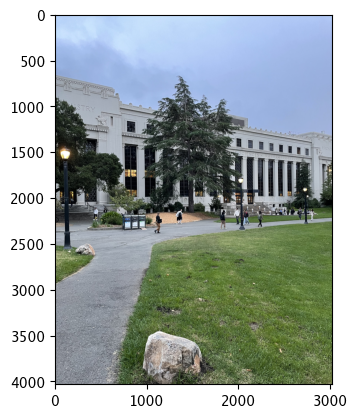

In [71]:
vlsb_1 = vlsb_images[0]
plt.imshow(vlsb_1)

In [188]:
vlsb_1_harris = get_harris_corners(vlsb_1)
vlsb_1_h, vlsb_1_coords = vlsb_1_harris

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


In [359]:
vlsb_1_coords = vlsb_1_coords.T
print(vlsb_1_coords.shape)

(62807, 2)


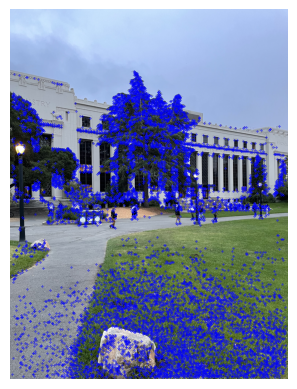

In [375]:
vlsb_1_top_coords = get_top_k(vlsb_1_h, vlsb_1_coords, k=10000)
plot_pts(vlsb_1_top_coords, size=.1, color='blue', label=False, swap=True)
plt.imshow(vlsb_1)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_1_harris', bbox_inches='tight')

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


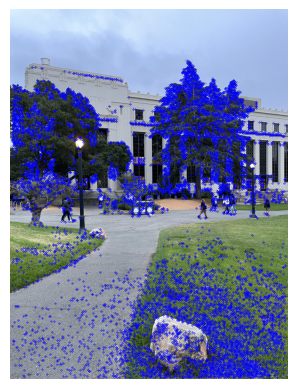

In [368]:
vlsb_2 = vlsb_images[1]
vlsb_2_harris = get_harris_corners(vlsb_2)
vlsb_2_h, vlsb_2_coords = vlsb_2_harris
vlsb_2_coords = vlsb_2_coords.T
vlsb_2_top_coords = get_top_k(vlsb_2_h, vlsb_2_coords, k=10000)

plot_pts(vlsb_2_top_coords, size=.1, color='blue', label=False, swap=True)
plt.imshow(vlsb_2)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_2_harris', bbox_inches='tight')

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


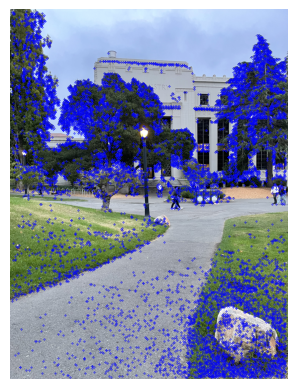

In [369]:
vlsb_3 = vlsb_images[2]
vlsb_3_harris = get_harris_corners(vlsb_3)
vlsb_3_h, vlsb_3_coords = vlsb_3_harris
vlsb_3_coords = vlsb_3_coords.T
vlsb_3_top_coords = get_top_k(vlsb_3_h, vlsb_3_coords, k=10000)

plot_pts(vlsb_3_top_coords, size=.1, color='blue', label=False, swap=True)
plt.imshow(vlsb_3)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_3_harris', bbox_inches='tight')

In [195]:
def adapt_non_max_supp(pts, h, num_pts=250, c_robust=0.99):
    num_inp_pts = pts.shape[0]
    
    dist = dist2(pts, pts)
    dist_sorted_idx = np.argsort(dist)
    
    r_vals = -np.ones(num_inp_pts)
    r_idx = -np.ones(num_inp_pts)
    for i in range(num_inp_pts):    # for each pt i
        for j in dist_sorted_idx[i]: # go through neighboring pts in sorted order by dist
            if h[pts[i][0], pts[i][1]] < c_robust * h[pts[j][0], pts[j][1]]: # until we find a stronger pt
                r_vals[i] = dist[i][j]
                r_idx[i] = j
                break

    # r_vals = -np.ones(num_inp_pts)
    # r_idx = -np.ones(num_inp_pts)
    # for i in range(num_inp_pts):
    #     print(pts[i])
    #     stronger_pts = np.where(h[pts[i][0], pts[i][1]] < c_robust * h[pts[dist_sorted_idx[i]][0], pts[dist_sorted_idx[i]][1]])[0]
    #     if stronger_pts.size > 0:
    #         r_vals[i] = dist[i, dist_sorted_idx[i][stronger_pts[0]]]
    #         r_idx[i] = dist_sorted_idx[i][stronger_pts[0]]
    sorted_r_idx = np.argsort(-r_vals)
    # print(r_vals[sorted_r_idx][:10])
    return pts[sorted_r_idx]

# Perform adaptive non-maxmimal suppression on an image, by first calculating the harris corners, choosing the k best corners, and then performing 
# ANMS on these top k corners to return a sorted list of corners
def anms_on_img(img, k=4000, num_pts=250, c_robust=0.99):
    img_harris = get_harris_corners(img)
    h, pts = img_harris
    pts = pts.T
    pts_top_k = get_top_k(h, pts, k=k)
    return adapt_non_max_supp(pts_top_k, h, num_pts=num_pts, c_robust=c_robust)[:num_pts]

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


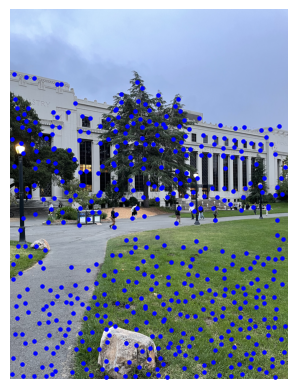

In [370]:
best_corners_vlsb_1 = anms_on_img(vlsb_1, k=10000, num_pts=500)
plot_pts(best_corners_vlsb_1, size=5, color='blue', label=False, swap=True)

plt.imshow(vlsb_1)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_1_anms', bbox_inches='tight')

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


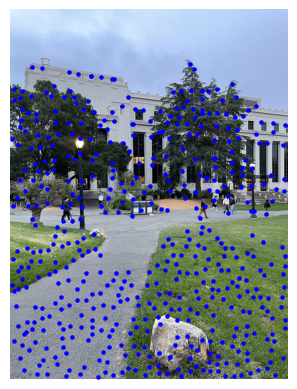

In [371]:
best_corners_vlsb_2 = anms_on_img(vlsb_2, c_robust=0.99, k=10000, num_pts=500)
plot_pts(best_corners_vlsb_2, size=5, color='blue', label=False, swap=True)

plt.imshow(vlsb_2)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_2_anms', bbox_inches='tight')

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


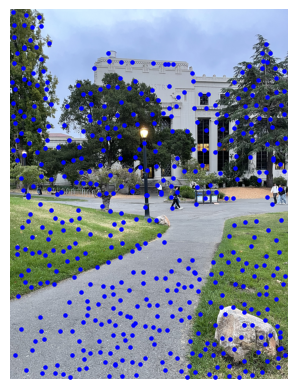

In [372]:
vlsb_3 = vlsb_images[2]
best_corners_vlsb_3 = anms_on_img(vlsb_3, k=10000, num_pts=500)
plot_pts(best_corners_vlsb_3, size=5, color='blue', label=False, swap=True)

plt.imshow(vlsb_3)
plt.axis('off')
plt.savefig(part_1_out_dir+'vlsb_3_anms', bbox_inches='tight')

### Part 2: Feature Descriptors

In [166]:
def normalize(a, channels=True):
    if channels:
        a -= np.mean(a, axis=tuple(range(a.ndim-1)))
        a /= np.std(a, axis=tuple(range(a.ndim-1)))
    else:
        a -= np.mean(a)
        a /= np.std(a)        
    return a

def compute_feature_descriptors(img, points):
    size = 20
    num_pts = points.shape[0]
    patches = np.zeros((num_pts, 8, 8))  # Compute 8x8x3 patches
    for i in range(num_pts):
        point = points[i]
        # Downsample patch centered at the feature point 
        patch = img[point[0]-size:point[0]+size, point[1]-size:point[1]+size]
        patch_gs = rgb2gray(patch)
        patch = downsample(patch_gs, scale_factor=5, channels=False)
        # Normalize
        # print(channel_mean, channel_std)
        patches[i] = normalize(patch, channels=False)
    # patches = normalize(patches, batch=True)
    return patches

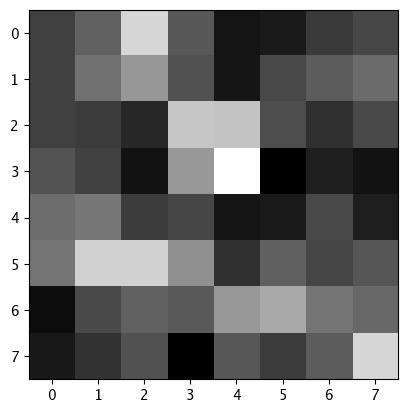

In [377]:
vlsb_patches = compute_feature_descriptors(vlsb_1, best_corners_vlsb_1)
plt.imshow(vlsb_patches[0], cmap='gray')
plt.savefig('images_out/part_b/part_2/patch')

### Part 3: Feature Matching using SSD and Lowe of thresholding

In [335]:
def k_lowest_indices_per_row(arr, k):
    return np.argpartition(arr, range(k))[:, :k]

def match_feature_patches(patches_1, patches_2, threshold=0.4):
    patches_flat_1 = einops.rearrange(patches_1, 'b h w -> b (h w)')
    patches_flat_2 = einops.rearrange(patches_2, 'b h w -> b (h w)')

    num_pts_1, feature_dim_1 = patches_flat_1.shape
    num_pts_2, feature_dim_2 = patches_flat_2.shape
    assert feature_dim_1 == feature_dim_2
    
    # ssd_sim = patches_flat_1 @ patches_flat_2.T / feature_dim_1
    ssd_sim = dist2(patches_flat_1, patches_flat_2)
    # np.fill_diagonal(ssd_sim, 0)
    nn_idx = k_lowest_indices_per_row(ssd_sim, k=2)
    # first_nn_indices = np.argmax(ssd_sim, axis=1)
    # second_nn_indices = np.argpartition(-ssd_sim, 2, axis=1)[:, 1]
    
    ratios = ssd_sim[np.arange(num_pts_1), nn_idx[:, 0]] / ssd_sim[np.arange(num_pts_1), nn_idx[:, 1]]
    # ratios_sorted_idx = np.argsort(ratios)
    mask = ratios < threshold
    mask = np.nonzero(mask) # indices of image1 which we select
    matches = nn_idx[:, 0] # nn of each image1 patch
    img1_pts_idx = mask
    img2_pts_idx = matches[mask]
    return ratios, img1_pts_idx, img2_pts_idx

# Combine Harris corner detection, ANMS, and feature descriptor extraction 
# to determine correspondence points automatically
def auto_correspondence(img1, img2, img3, k=12000, num_pts=500):
    # Use Harris Corner detection + ANMS to get feature points
    best_corners_1 = anms_on_img(img1, k=k, num_pts=num_pts)
    best_corners_2 = anms_on_img(img2, k=k, num_pts=num_pts)
    best_corners_3 = anms_on_img(img3, k=k, num_pts=num_pts)

    # Compute patches
    best_patches_1 = compute_feature_descriptors(img1, best_corners_1)
    best_patches_2 = compute_feature_descriptors(img2, best_corners_2)
    best_patches_3 = compute_feature_descriptors(img3, best_corners_3)
    
    # Match Patches with SSD similarity and thresholding
    res_12 = match_feature_patches(best_patches_1, best_patches_2)
    ratios, img1_pts_idx, img2_pts_idx = res_12
    ret_12 = (best_corners_1[img1_pts_idx], best_corners_2[img2_pts_idx])
    
    res_32 = match_feature_patches(best_patches_3, best_patches_2)
    ratios, img3_pts_idx, img2_pts_idx = res_32
    ret_32 = (best_corners_3[img3_pts_idx], best_corners_2[img2_pts_idx])

    return ret_12, ret_32


In [254]:
vlsb_patches_1 = compute_feature_descriptors(vlsb_1, best_corners_vlsb_1)
vlsb_patches_2 = compute_feature_descriptors(vlsb_2, best_corners_vlsb_2)
vlsb_patches_3 = compute_feature_descriptors(vlsb_3, best_corners_vlsb_3)

In [255]:
res_12 = match_feature_patches(vlsb_patches_1, vlsb_patches_2)
res_23 = match_feature_patches(vlsb_patches_2, vlsb_patches_3)

132


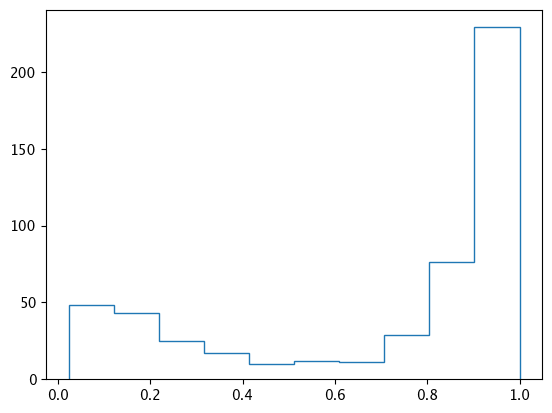

In [256]:
ratios, img1_pts_idx, img2_pts_idx = res_12
print(np.count_nonzero(ratios < 0.4))
counts, bins = np.histogram(ratios)
plt.stairs(counts, bins)

46


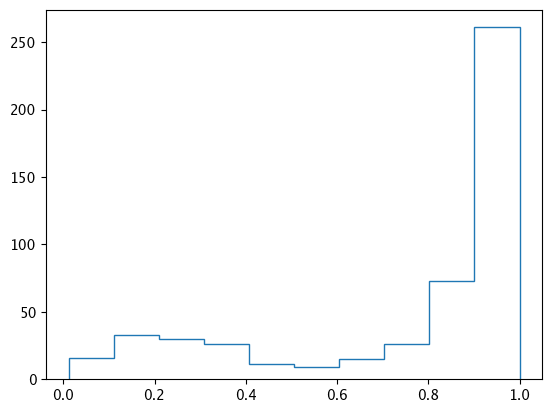

In [257]:
ratios, img1_pts_idx, img2_pts_idx = res_23
print(np.count_nonzero(ratios < 0.2))
counts, bins = np.histogram(ratios)
plt.stairs(counts, bins)

In [311]:
# vlsb12_1_pts, vlsb12_2_pts = auto_correspondence(vlsb_1, vlsb_2)
# vlsb23_2_pts, vlsb23_3_pts = auto_correspondence(vlsb_2, vlsb_3)
points_12, points_32 = auto_correspondence(vlsb_3, vlsb_2, vlsb_1, k=10000, num_pts=500)
vlsb12_1_pts, vlsb12_2_pts = points_12
vlsb23_3_pts, vlsb23_2_pts = points_32

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


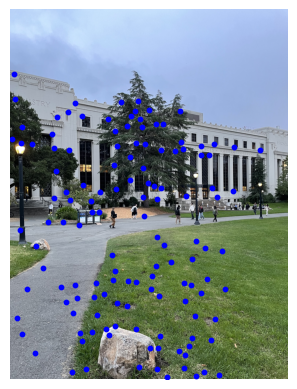

In [378]:
out_dir = 'images_out/part_b/part_3/'
plot_pts(vlsb23_3_pts, size=10, color='blue', label=False, swap=True)
plt.imshow(vlsb_1)
plt.axis('off')
plt.savefig(out_dir + 'vlsb_1', bbox_inches='tight')

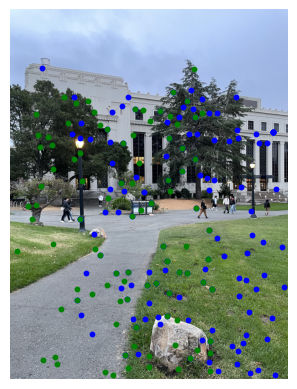

In [379]:
plot_pts(vlsb23_2_pts, size=10, color='blue', label=False, swap=True)
plot_pts(vlsb12_2_pts, size=10, color='green', label=False, swap=True)

plt.imshow(vlsb_2)
plt.axis('off')
plt.savefig(out_dir + 'vlsb_2',bbox_inches='tight')

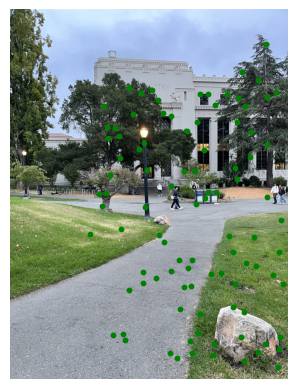

In [380]:
plot_pts(vlsb12_1_pts, size=10, color='green', label=False, swap=True)
plt.imshow(vlsb_3)
plt.axis('off')
plt.savefig(out_dir + 'vlsb_3',bbox_inches='tight')

### Part 4 RANSAC

In [399]:
np.random.seed(1)
def ransac_compute_h(pts_1, pts_2, need_swap=False, num_iter=2000, epsilon=1):
    num_pts = pts_1.shape[0]
    curr_err = 10**9
    inlier_idx = []
    # if need_swap:
    #     pts_1[:, [0, 1]] = pts_1[:, [1, 0]]
    #     pts_2[:, [0, 1]] = pts_2[:, [1, 0]]

    for i in range(num_iter):
        # 1. select n feature pairs at random
        subset_idx = np.random.choice(num_pts, size=6, replace=False)
        subset_1, subset_2 = pts_1[subset_idx], pts_2[subset_idx]
        
        # 2. Compute H
        H_1_to_2,_,_ = compute_h(subset_1, subset_2)
        
        # 3. Compute inliers where dist(p', Hp) < epsilon across all points
        H_p = apply_h(H_1_to_2, pts_1)
        err = np.linalg.norm(H_p-pts_2, axis=1)
        cur_inliers = np.nonzero(err < epsilon)[0]

        # 4. Update inliers set
        if len(cur_inliers) > len(inlier_idx) or (np.mean(err) < curr_err and len(cur_inliers) == len(inlier_idx)):
            inlier_idx = cur_inliers
            curr_err
                
    # Recompute H on final set of inliers
    print(len(inlier_idx))
    final_H,_,_ = compute_h(pts_1[inlier_idx], pts_2[inlier_idx])
    return final_H

In [405]:
vlsb_H_1_to_2 = ransac_compute_h(vlsb12_1_pts, vlsb12_2_pts, epsilon=1)

22


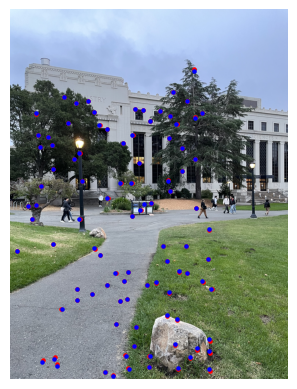

In [409]:
mapped_pts = apply_h(vlsb_H_1_to_2, vlsb12_1_pts)
plot_pts(vlsb12_2_pts, color='red', label=False, swap=True)
plot_pts(mapped_pts, color='blue', label=False, swap=True)
plt.imshow(vlsb_2)
plt.axis('off')
out_dir = 'images_out/part_b/part_4/'
plt.savefig(out_dir+'vlsb_2', bbox_inches='tight')

### Part 5: Mosaics

In [302]:
# Code from 4A
# Applies homography to img
def warp_new(H, img, corners, new_shape = None, offset=[0,0], color_interp=None, out_dir='images_out/part_b/part_2/', fname=None):
    if new_shape == None: new_shape = img.shape
    new_image = np.zeros(new_shape)
    cc, rr = create_polygon(corners)
    cc -= offset[0]
    rr -= offset[1]
    src_coords = np.array([cc, rr, np.ones_like(rr)])
    
    new = homogenous_to_non(get_inv(H) @ src_coords)   # Apply transformation to get pts in original image
    c_n, r_n = new[:, 0], new[:, 1]

    # Interpolate at to get the colors of the points when inv mapped
    mask_c = c_n < img.shape[1]
    mask_c *= c_n >= 0
    mask_c = np.repeat(mask_c[:, np.newaxis], 3, axis=1)

    mask_r = r_n < img.shape[0]
    mask_r *= r_n >= 0
    mask_r = np.repeat(mask_r[:, np.newaxis], 3, axis=1)
    # mask = mask_r * mask_c

    if color_interp == None:
        color_interp = create_interp_grid(img)
    tri_interp = color_interp((r_n, c_n))
    tri_interp_mask_c = np.where(mask_c, tri_interp, np.zeros(3))
    tri_interp_mask_rc = np.where(mask_r, tri_interp_mask_c, np.zeros(3))

    # new_image[rr, cc] = tri_interp
    cc += offset[0]
    rr += offset[1]
    rr = np.clip(rr, 0, new_image.shape[0]-1)
    cc = np.clip(cc, 0, new_image.shape[1]-1)

    new_image[rr, cc] = tri_interp_mask_rc
    # plt.imshow(new_image)
    if fname != None:
        save_img(fname, new_image, out_dir=out_dir)
    return new_image

def translate_img(img, new_shape, offset_x=0, offset_y=0):
    new_img = np.zeros(new_shape)
    upper_y = min(offset_y+img.shape[0], new_img.shape[0])
    upper_x = min(offset_x+img.shape[1], new_img.shape[1])
    new_img[offset_y:upper_y, offset_x:upper_x] = img[:upper_y-offset_y, :upper_x-offset_x]
    return new_img

def make_mask_3_channel(mask):
    new_mask = np.zeros((mask.shape[0],mask.shape[1],3))
    new_mask[:,:,0] = mask
    new_mask[:,:,1] = mask
    new_mask[:,:,2] = mask
    return new_mask

def or_masks(masks):
    masks = np.sum(masks, axis=0)
    return np.clip(masks, 0, 1)

def and_masks(masks):
    masks = np.sum(masks, axis=0)
    masks = (masks > 1).astype(int).astype(float)
    return np.clip(masks, 0, 1)

def xor_masks(masks):
    return 1-or_masks(masks)

# Computes mask from the polygon defined by the img corners.
# Mask is 1 inside the image corners, 0 outside
def make_mask_from_corners(img, corners):
    mask_poly = create_polygon(corners)
    cc, rr = mask_poly
    mask = np.zeros(img.shape[:2])

    rr = np.clip(rr, 0, mask.shape[0]-1)
    cc = np.clip(cc, 0, mask.shape[1]-1)
    mask[rr,cc] = 1
    mask = make_mask_3_channel(mask)
    return mask

def compute_offset_from_corners(corners):
    max_x = int(np.max(corners[:,0]))
    min_x = int(np.min(corners[:,0]))
    max_y = int(np.max(corners[:,1]))
    min_y = int(np.min(corners[:,1]))
    
    offset_y = abs(min(0, (min_y)))
    offset_x = abs(min(0, (min_x)))
    return np.asarray([offset_x, offset_y])

In [336]:
# Same code as 4A, but with homographies computed with RANSAC
def swap_xy(pts):
    pts[:, [0,1]] = pts[:, [1,0]]
    
def alpha_blend_mosaic(images, masks):
    return images[0] * (1-or_masks(masks[1:])) + masks[1]*images[1] + (1-masks[1]) * images[2]

def compute_mosaic(name, l=3, c=2, r=1, size_x=5500, size_y=5500, offset_extra_x=0, offset_extra_y=0, use_ransac=True, scale_factor=4):
    l,c,r = str(l), str(c), str(r)
    
    # Load images
    if use_ransac:
        img_dir = 'images_out/part_b/part_1/'
        img_set = read_image_set(name, abs(int(l)-int(c)),
                                 scale_factor=scale_factor,
                                 transpose=True,
                                 save=False)
        if l < r:
            img_left, img_center, img_right = img_set
        else:
            img_right, img_center, img_left = img_set
    else:
        img_dir = 'images_in/'
        img_left = read_img(name + '_'+l, img_dir, r=3)
        img_center = read_img(name + '_'+c, img_dir, r=3)
        img_right = read_img(name + '_'+r, img_dir, r=3)
    # plt.imshow(img_center)
    # Load points
    if use_ransac:
        map_12_pts, map_32_pts = auto_correspondence(img_left, img_center, img_right)
        left_12_pts, center_12_pts = map_12_pts
        right_32_pts, center_32_pts= map_32_pts
        swap_xy(left_12_pts)
        swap_xy(center_12_pts)
        swap_xy(right_32_pts)
        swap_xy(center_32_pts)
    else:
        pts_2_to_1, pts_2_to_3 = name + '_'+c+'_to_'+r, name + '_'+c+'_to_'+l
        center_32_pts, right_32_pts = load_corr_pts(pts_2_to_1, single=False)
    
    # Warp right to center
    right_interp = create_interp_grid(img_right) # Interpolate grid
    
    # Compute H
    if use_ransac:
        H_1_to_2 = ransac_compute_h(right_32_pts, center_32_pts, epsilon=1)
    else:
        H_1_to_2, _, _ = compute_h(right_32_pts, center_32_pts) 
    
    new_right_corners = apply_h(H_1_to_2, get_corners(img_right))
    # print(new_right_corners)
    offset_to_not_get_neg_1_to_2 = compute_offset_from_corners(new_right_corners)
    
    new_size_x, new_size_y = size_x, size_y
    img_1_to_2_warp = warp_new(H_1_to_2, img_right,
                                corners = new_right_corners + offset_to_not_get_neg_1_to_2,
                                new_shape=(new_size_y, new_size_x, 3),
                                # new_shape=(max(max_y, vlsb_right.shape[0]) - min(0, min_y), max(max_x, vlsb_right.shape[1]) - min(0, min_x), 3),
                                # new_shape=(max_y-min_y, max_x, 3),
                                offset=offset_to_not_get_neg_1_to_2, color_interp=right_interp)
    plt.imshow(img_1_to_2_warp)

    # Apply extra shift to align all center img in canvas
    extra_trans_after_1_to_2_warp = [1500+ offset_extra_x, 150+ offset_extra_y]
    total_shift = offset_to_not_get_neg_1_to_2 + extra_trans_after_1_to_2_warp
    
    img_1_to_2_warp_shift = translate_img(img_1_to_2_warp, img_1_to_2_warp.shape, 
                                          offset_y=extra_trans_after_1_to_2_warp[1], 
                                          offset_x=extra_trans_after_1_to_2_warp[0])
    trans_center_img = translate_img(img_center, img_1_to_2_warp_shift.shape, offset_x=total_shift[0], offset_y=total_shift[1])
    # plt.imshow(img_1_to_2_warp_shift)
    
    
    # Compute mask for right img
    right_corners_shifted = new_right_corners + total_shift
    center_corners = get_corners(img_center)
    center_corners_shifted = center_corners + total_shift
    
    mask_right = make_mask_from_corners(img_1_to_2_warp_shift, right_corners_shifted)
    mask_center = make_mask_from_corners(trans_center_img, center_corners_shifted)
    
    comb_init = img_1_to_2_warp_shift + trans_center_img*mask_right  
    # #################################################################################################
    ### Warp left to (center+right)
    # Load points

    if not use_ransac:
        pts_2_to_1, pts_2_to_3 = name + '_'+c+'_to_'+r, name + '_'+c+'_to_'+l
        center_12_pts, left_12_pts = load_corr_pts(pts_2_to_3, single=False)
    
    # Shift correspondence points using the current offset
    center_shift_pts = shift_pts(center_12_pts, offset_x=total_shift[0], offset_y=total_shift[1])
    
    left_interp = create_interp_grid(img_left) # Interpolate
    
    # Compute H for left to center
    if use_ransac:
        H_3_to_2 = ransac_compute_h(left_12_pts, center_shift_pts, epsilon=1)
    else:
        H_3_to_2, _, _ = compute_h(left_12_pts, center_shift_pts) 
    
    # Find offset to keep image idicies positive
    new_left_corners = apply_h(H_3_to_2, get_corners(img_left))
    offset_to_not_get_neg_3_to_2 = compute_offset_from_corners(new_left_corners)
    
    # plot_pts(new_left_corners + offset_to_not_get_neg_3_to_2, color='red')
    # Warp
    img_3_to_2_warp = warp_new(H_3_to_2, comb_init,
                                corners=new_left_corners+offset_to_not_get_neg_3_to_2,
                                new_shape=(new_size_y, new_size_x, 3),
                                # new_shape=(max(max_y, vlsb_left.shape[0]) + offset_y, max(max_x, vlsb_left.shape[1]) + offset_x, 3),
                                offset=offset_to_not_get_neg_3_to_2, color_interp=left_interp)
    
    left_corners_shifted = new_left_corners + offset_to_not_get_neg_3_to_2
    mask_left = make_mask_from_corners(img_3_to_2_warp, left_corners_shifted)

    #############################################
    ### returns all images and masks
    left, center, right = img_3_to_2_warp, trans_center_img, img_1_to_2_warp_shift
    images, masks = [left, center, right] , [mask_left, mask_center, mask_right]
    alpha_mosaic = alpha_blend_mosaic(images, masks)
    plt.imshow(alpha_mosaic)
    save_img(name+'_alpha_mosaic', alpha_mosaic, out_dir='images_out/part_b/part_5/')
    return images, masks
    

In [329]:
def rotate_images(name, l,c,r, out_dir='images_out/part_a/part_3/'):
    l,c,r = str(l), str(c), str(r)
    img_left = read_img(name + '_'+l, img_dir, r=3)
    img_center = read_img(name + '_'+c, img_dir, r=3)
    img_right = read_img(name + '_'+r, img_dir, r=3)
    
    save_img(name+l, img_left, out_dir=out_dir)
    save_img(name+r, img_right, out_dir=out_dir)
    save_img(name+c, img_center, out_dir=out_dir)

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


30
20


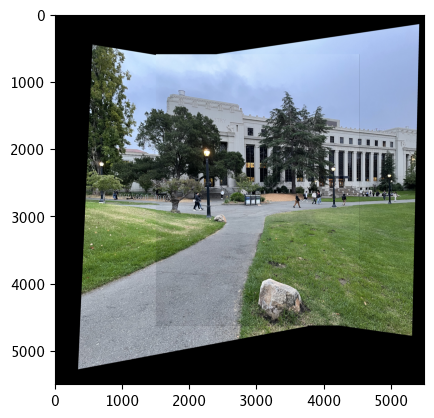

In [337]:
images_vlsb, masks_vlsb = compute_mosaic('vlsb', use_ransac=True, scale_factor=1)
# images_vlsb, masks_vlsb = compute_mosaic('vlsb', use_ransac=True, scale_factor=4)

In [11]:
rotate_images('garin', 1,2,3)
rotate_images('vlsb', 3,2,1)
rotate_images('evans', 1,3,5)

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


16
23


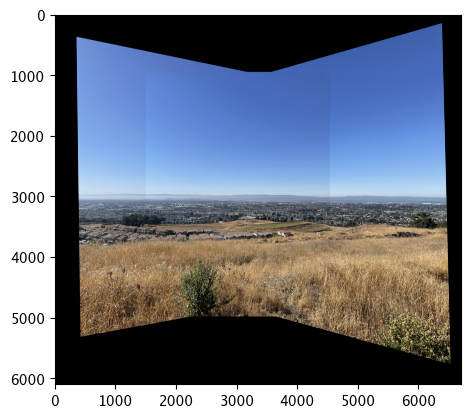

In [338]:
images_garin, masks_garin = compute_mosaic('garin', l=1, c=2, r=3, size_x=6700, size_y=6100, offset_extra_x=0, scale_factor=1)

/var/folders/0q/5pxc03555m17r77zjkftg0bw0000gn/T/ipykernel_91941/3909009389.py:22: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  coords = peak_local_max(h, min_distance=min_dist, indices=True)


19
23


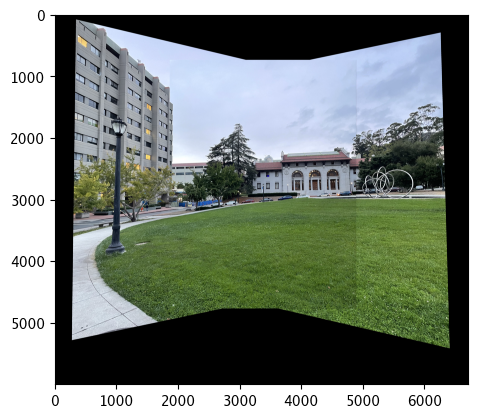

In [339]:
images_evans, masks_evans = compute_mosaic('evans', l=1, c=3, r=5, size_x=6700, size_y=6000, offset_extra_x=360, offset_extra_y=150, scale_factor=1)

In [344]:
def reshape(img, img_to_match):
    new_img = np.zeros_like(img_to_match)
    new_img[:img.shape[0], :img.shape[1], :] = img
    return new_img

In [345]:
dx = np.array([[1, -1]])
dy = np.array([[1], [-1]])
def convolve(filter, img):
    # res = scipy.signal.convolve(img, filter, mode='same')
    # res = scipy.signal.fftconvolve(img, filter, mode='same')
    res = scipy.signal.convolve2d(img, filter, mode='same', boundary='symm')
    # res = np.clip(res, a_min=0, a_max=1)
    return res

def create_gaussian_2d(sigma=3, ksize=19):
    gaussian_1d = cv2.getGaussianKernel(ksize, sigma)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    return gaussian_2d


def create_unit_impulse(filter_shape):
    unit_impulse = np.zeros((filter_shape))
    unit_impulse[unit_impulse.shape[0]//2, unit_impulse.shape[1]//2,] = 1
    return unit_impulse

def create_sharpening_filter(alpha, sigma=3, ksize=18):
    gaussian = create_gaussian_2d(sigma, ksize)
    unit_impulse = create_unit_impulse(gaussian.shape)
    return (1+alpha) * unit_impulse - alpha * gaussian

def convolve_color(filter, img, color=True):
    res = np.zeros_like(img)
    if color:
        res[:,:,0] = convolve(filter, img[:,:,0])
        res[:,:,1] = convolve(filter, img[:,:,1])
        res[:,:,2] = convolve(filter, img[:,:,2])
    else:
        res = convolve(filter, img)
    return res

def opt_ksize(sigma):
    return 6*sigma+1

rgb_2_gray = lambda rgb : np.dot(rgb[... , :3] , [0.299 , 0.587, 0.114])
def add_images(img1, img2):
    c1, c2 =  img1.shape[2] if len(img1.shape) > 2 else 0, img2.shape[2] if len(img2.shape) > 2 else 0
    combined = np.zeros_like(img1) if c1 > c2 else np.zeros_like(img2)
    if c1 > c2:
        for c in range(c1):
            combined[:,:,c] = img1[:,:,c] + img2
    elif c2 > c1:
        for c in range(c2):
            combined[:,:,c] = img2[:,:,c] + img1
    else:
        if c1 > 0:
            for c in range(c1):
                combined[:,:,c] = img2[:,:,c] + img1[:,:,c]
        else:
            combined = img2 + img1
    return combined

In [346]:
import skimage

def rescale_single(a):
    return np.interp(a, (a.min(), a.max()), (0, 1))

def rescale_all_channels(a):
    res = np.zeros_like(a)
    for c in range(a.shape[-1]):
        res[:,:,c] = rescale_single(a[:,:,c])
    return res
    
def create_gaussian_stack(img, levels, sigma=10):
    stack = np.zeros((levels, img.shape[0], img.shape[1], img.shape[2]))
    gaussian_2d = create_gaussian_2d(sigma, opt_ksize(sigma))
    
    stack[0] = img
    prev = stack[0]
    for i in range(1,levels):
        stack[i] = convolve_color(gaussian_2d, prev)
        prev = stack[i]
    return stack

def create_laplacian_stack(gaussian_stack):
    levels = gaussian_stack.shape[0] - 1
    laplacian_stack = np.zeros((levels, gaussian_stack.shape[1], gaussian_stack.shape[2], gaussian_stack.shape[3]))
    
    for i in range(levels):
        laplacian_stack[i] = gaussian_stack[i] - gaussian_stack[i+1]
    return laplacian_stack

def create_stacks(img, levels, sigma=10):
    gaussian_stack = create_gaussian_stack(img, levels+1, sigma)
    laplacian_stack = create_laplacian_stack(gaussian_stack)
    return laplacian_stack, gaussian_stack

def plot_stack(stack, save=False, vertical=False, fname='', show=True):
    levels = stack.shape[0]
    if vertical:
        fig, axes = plt.subplots(levels, 1, figsize=(20, 10))
    else:
        fig, axes = plt.subplots(1, levels, figsize=(10, 20))

    for i, ax in enumerate(axes.flat):
        ax.imshow(rescale_single(stack[i]))  
        ax.axis('off') 
    plt.tight_layout()

    if save:
        plt.savefig('part2_out_dir/part2_3/' + fname + '.jpg',bbox_inches='tight')
    
    if show:
        plt.show()
    
def sum_two_stack(stack1, stack2):
    left = np.sum(stack1, axis=0)
    right = np.sum(stack2, axis=0)
    left_extra_dim = left[np.newaxis, ...]
    right_extra_dim = right[np.newaxis, ...]

    stack1 = np.concatenate((stack1, left_extra_dim))
    stack2 = np.concatenate((stack2, right_extra_dim))

    combined = stack1 + stack2
    return left+right, stack1, stack2, combined

def create_masked_stack(img_stack, mask_stack, invert=False):
    masked_img_stack = np.zeros_like(img_stack)
    if invert:
        mask_stack = 1 - mask_stack
    levels = img_stack.shape[0]
    for i in range(levels):
        masked_img_stack[i] = img_stack[i] * mask_stack[i]
    return masked_img_stack

# Applies the mask onto img1, the inverse onto img2, creates a Laplacian stack, and then returns the collapsed image
def multires_blend(img1, img2, mask, mask_2=None, img_sigma=4, mask_sigma=20, levels=2, save=False, fnames=[], show=False):
    new_mask = mask
    if mask.shape != img1.shape:
        mask = make_mask_3_channel(mask)
    if np.any(mask_2) == None:
        mask_2 = 1-mask
    print(new_mask.shape)
    img1_laplacian_stack, img1_gaussian_stack = create_stacks(img1, levels, img_sigma)
    img2_laplacian_stack, img2_gaussian_stack = create_stacks(img2, levels, img_sigma)

    img1_laplacian_stack[levels-1] = img1_gaussian_stack[levels]
    img2_laplacian_stack[levels-1] = img2_gaussian_stack[levels]
    
    mask_stack = create_gaussian_stack(mask, levels, sigma=mask_sigma)
    mask_2_stack = create_gaussian_stack(mask_2, levels, sigma=mask_sigma)

    masked_stack1 = create_masked_stack(img1_laplacian_stack, mask_stack, invert=False)
    masked_stack2 = create_masked_stack(img2_laplacian_stack, mask_2_stack, invert=False)
    if show:
        plot_stack(mask_stack)
    # plot_stack(mask_2_stack)
    final_img, left, right, combined = sum_two_stack(masked_stack1, masked_stack2)
    
    if show:
        plot_stack(left)
        plot_stack(combined)
        plot_stack(right)
    if save:
        save_img(fnames[1], final_img, out_dir='part2_out_dir/part2_4/')
    return final_img, left, combined, right, img1_laplacian_stack, img2_laplacian_stack, img1_gaussian_stack, img2_gaussian_stack

def create_vertical_mask(img, y):
    left_ones = np.zeros_like(img)
    left_ones[:, :y] = 1
    return left_ones

In [347]:
def combine_with_mask(img1, img2, mask):
    return img1*mask + img2*(1-mask)

# Compute mutually exclusive binary mask using distance transform
def get_dist_mask(mask_1,mask_2):
    dist_1 = scipy.ndimage.distance_transform_edt(mask_1).astype(float)
    dist_1 = dist_1/np.max(dist_1)
    dist_2 = scipy.ndimage.distance_transform_edt(mask_2).astype(float)
    dist_2 = dist_2/np.max(dist_2)
    dist_1_2 = (dist_1 > dist_2).astype(int).astype(float)
    return dist_1_2

# Blend using just the binarized distance transforms
def dist_blend(images, masks):
    dist_mask_2_1 = get_dist_mask(masks[1], masks[2])
    combined_1_2 = combine_with_mask(images[1], images[2], dist_mask_2_1)
    
    dist_mask_12_0 = get_dist_mask(or_masks(masks[1:]), masks[0])
    combined_full = combine_with_mask(combined_1_2, images[0], dist_mask_12_0)
    return combined_full

# Blend using distance transform and laplacian pyramids
def dist_blend_laplacian(images, masks,levels=2, img_sigma=3, mask_sigma=5,show=False):
    # Combine center and right
    img1 = images[1]
    img2 = images[2]
    dist_mask_2_1 = get_dist_mask(masks[1], masks[2])
    white_space = xor_masks(masks[1:])
    mask_1 = or_masks([dist_mask_2_1,white_space])
    mask_2 = or_masks([1-dist_mask_2_1,white_space])

    res = multires_blend(img1, img2, mask_1,mask_2,
                        img_sigma=img_sigma, mask_sigma=mask_sigma, levels=levels,
                        save=False,show=show)
    combined_1_2 = res[0]
    
    # # Combine (center+right) and left
    img1 = combined_1_2
    img2 = images[0]

    combined_1_2_mask = or_masks(masks[1:])
    dist_mask_1_0 = get_dist_mask(combined_1_2_mask, masks[0])
    white_space = xor_masks([combined_1_2_mask, masks[0]])

    mask_1 = or_masks([dist_mask_1_0,white_space])
    mask_2 = or_masks([1-dist_mask_1_0,white_space])

    res = multires_blend(img1, img2, mask_1,mask_2,
                        img_sigma=img_sigma, mask_sigma=mask_sigma, levels=levels,
                        save=False, show=show)
    all_masks = xor_masks([masks[0], combined_1_2_mask])
    return res[0] + all_masks
    # return combined_1_2

In [348]:
# scale_factor = 1/(2**3)
# images_vlsb_ds_8 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_vlsb]
# masks_vlsb_ds_8 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_vlsb]

In [349]:
scale_factor = 1/(2**2)
images_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_garin]
masks_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_garin]

In [350]:
scale_factor = 1/(2**2)
images_vlsb_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_vlsb]
masks_vlsb_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_vlsb]

In [351]:
scale_factor = 1/(2**2)
images_evans_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_evans]
masks_evans_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in masks_evans]

In [ ]:
evans_ds_4 = dist_blend_laplacian(images_evans_ds_4, masks_evans_ds_4, levels=6,img_sigma=4, mask_sigma=8, show=False)
plt.imshow(evans_ds_4)
evans_ds_4_xor = evans_ds_4 - xor_masks(masks_evans_ds_4)
out_dir='images_out/part_b/part_5/'
save_img('evans_ds_4_6_8', evans_ds_4, out_dir=out_dir)
save_img('evans_ds_4_6_8_xor', evans_ds_4_xor, out_dir=out_dir)

In [354]:
save_img('evans_ds_4_6_8', evans_ds_4, out_dir=out_dir)
save_img('evans_ds_4_6_8_xor', evans_ds_4_xor, out_dir=out_dir)

(1525, 1675, 3)


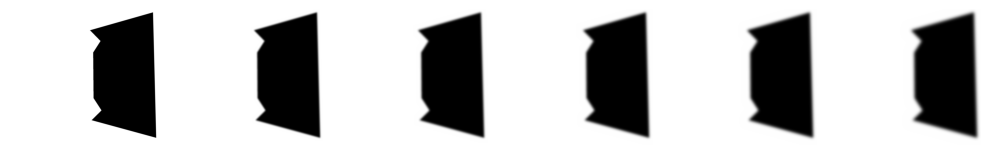

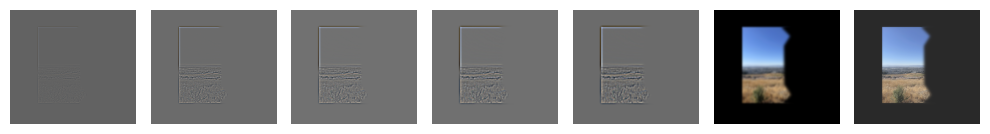

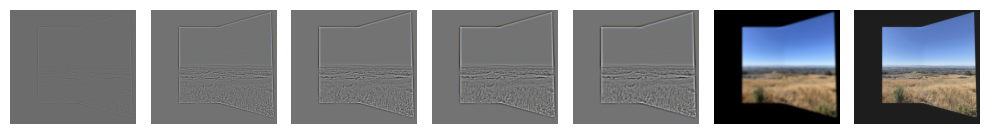

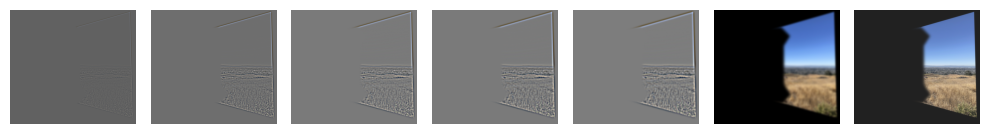

(1525, 1675, 3)


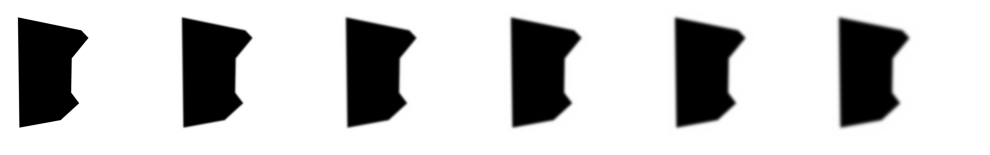

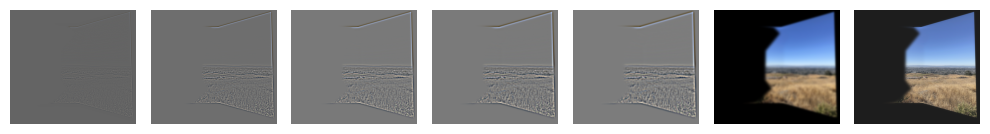

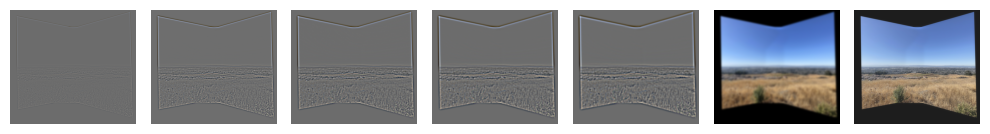

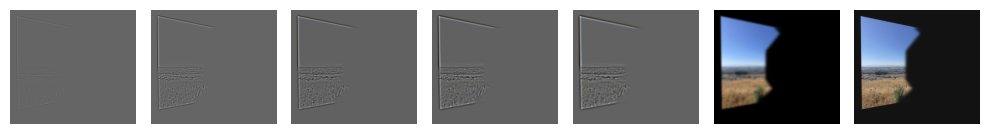

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


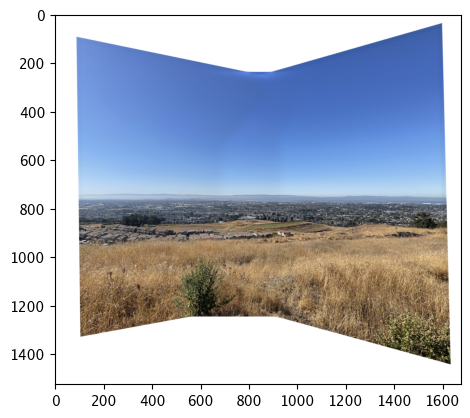

In [355]:
garin_ds_4 = dist_blend_laplacian(images_garin_ds_4, masks_garin_ds_4, levels=6,img_sigma=4, mask_sigma=8, show=True)
plt.imshow(garin_ds_4)
garin_ds_4_xor = garin_ds_4 - xor_masks(masks_garin_ds_4)
save_img('garin_ds_4_6_8', garin_ds_4, out_dir=out_dir)
save_img('garin_ds_4_6_8_xor', garin_ds_4_xor, out_dir=out_dir)

(1375, 1375, 3)


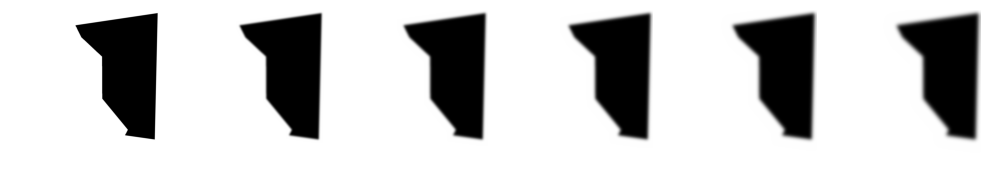

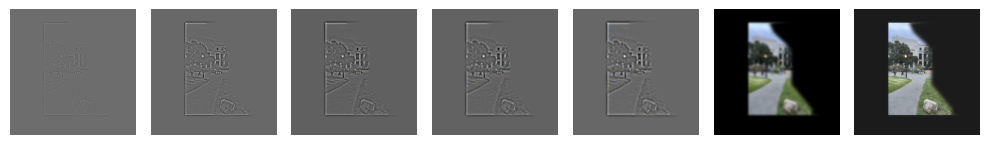

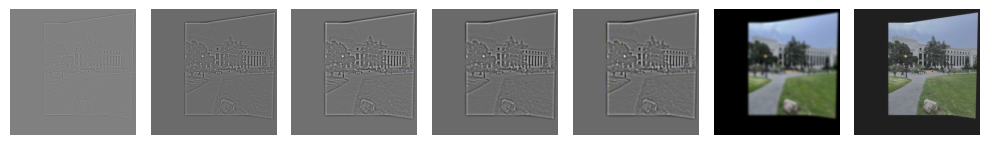

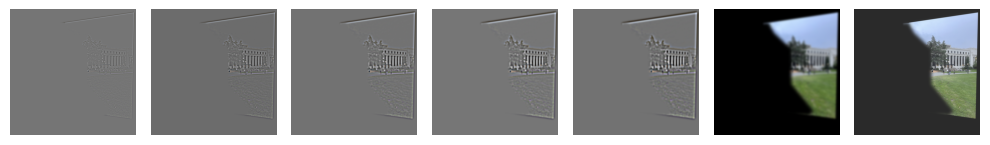

(1375, 1375, 3)


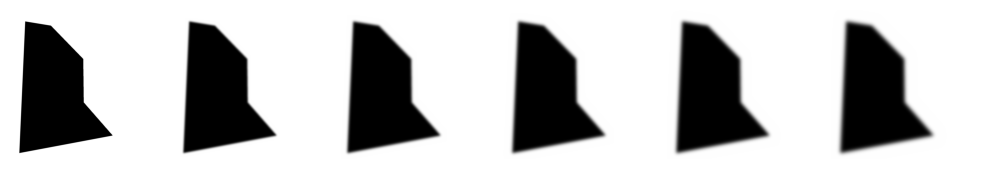

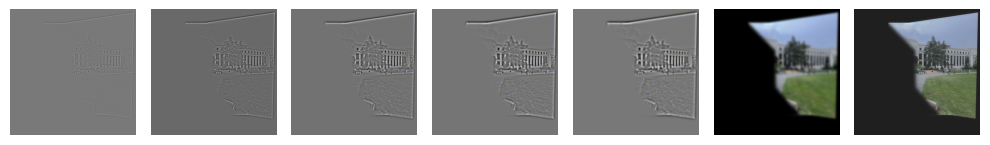

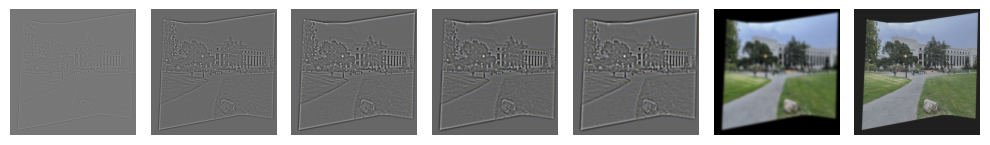

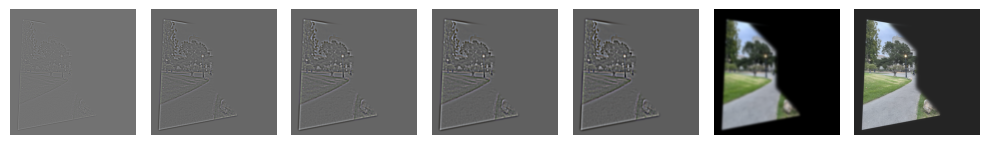

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


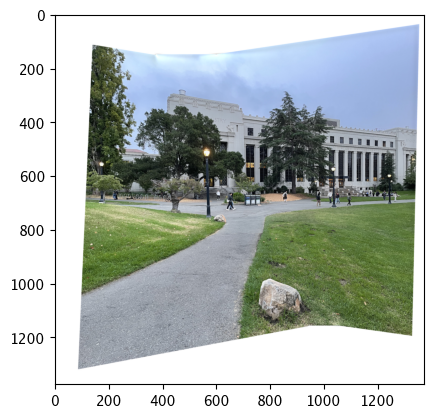

In [356]:
vlsb_ds_4 = dist_blend_laplacian(images_vlsb_ds_4, masks_vlsb_ds_4, levels=6,img_sigma=4, mask_sigma=8, show=True)
plt.imshow(vlsb_ds_4)
vlsb_ds_4_xor = vlsb_ds_4 - xor_masks(masks_vlsb_ds_4)
save_img('vlsb_ds_4_6_8', vlsb_ds_4, out_dir=out_dir)
save_img('vlsb_ds_4_6_8_xor', vlsb_ds_4_xor, out_dir=out_dir)

In [ ]:
images_garin_ds_4 = [skimage.transform.rescale(img, scale_factor, anti_aliasing=True,channel_axis=-1) for img in images_garin]


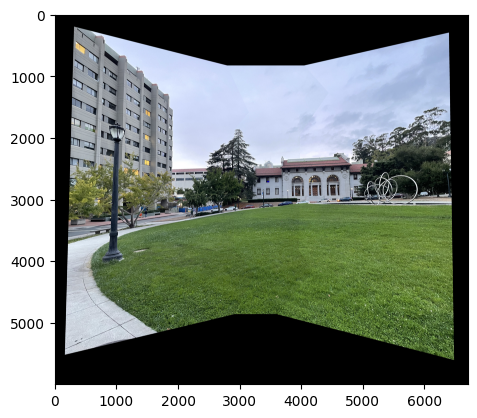

In [277]:
combined = dist_blend(images_evans, masks_evans)
plt.imshow(combined)
save_img('evans_dist', combined)

In [22]:
save_img('ds_garin', images_garin_ds_4[1])